# Report 2. ML algorithm

Este notebook desarrolla el algoritmo de machine learning de reconocimiento facial.

    Hacer mas explicativo el paso a paso... Resumen del notebook
    
PROBLEMA: hacer un classical ML algorithm que clasifique fotos de 10 personas distintas. 

.

#### Proceso:
1. Escaleo estandar (scaler.pkl)
2. Reduccion de dimensionalidad (pca.pkl)
3. Modelo (SVC + RandomSearch)

In [149]:
# Para mas placer...
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [150]:
######
#Esta celda importa las librerias necesarias para graficar imagenes y trabajar con la libreria de sklearn. 
######

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


# Common imports
import numpy as np
import os
from time import time

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
### Defino una función para presentar los scores 
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    return

def metricas(y_true, y_predict):
    #print('Accuaracy: ', accuracy_score(y_true, y_predict))
    #print('Precision: ', precision_score(y_true, y_predict))
    #print('Recall', recall_score(y_true, y_predict))
    #print('F1', f1_score(y_true, y_predict))
    print(classification_report(y_true, y_predict))

## Cargo los datos de train y validation

In [151]:
# importo los datos
import pickle
with open('faces_dict_train.p', 'rb') as handle:
        train = pickle.load(handle)
with open('faces_dict_valid.p', 'rb') as handle:
        valid = pickle.load(handle)

X_train=train['X']
y_train=train['y']
X_valid=valid['X']
y_valid=valid['y']

### Conociendo un poco el train
* Grafico algunos datos del train

(**COMPLETAR**)

### Escaleo estandar 
* Voy a trabajar con el standarscaler. 
* Grafico de nuevo algunos datos del train para ver como cambio. (debo usar las dimensiones de la matriz para esto _h_ * _w_ : 64 * 64) 

In [152]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Guardo el scaler
pickle.dump(scaler,open('scaler.pkl', 'wb'))

### Reduccion de dimensionalidad (PCA) 
* Recordemos que hay 64x64=4064 'features' (cantidad de pixeles) y solo 280 imagen para entrenar el modelo... Voy a hacer una reducción de dimensionalidad con **PCA**.

* De paso, saco las _autocaras_ obtenidas del PCA que el modelo va a usar para clasificary las 'chusmeo'.

In [167]:
#pca = PCA(0.99, whiten=True) #varianza mayor al 99%
pca = PCA(10, whiten=True) 
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
print('n_components %d'%pca.n_components_)

print("Se extrajo %d 'autocaras' de %d caras" % (pca.n_components_, X_train.shape[0]))
eigenfaces = pca.components_.reshape((pca.n_components_, h, w))

# Guardo el PCA
pickle.dump(pca,open('PCA.pkl', 'wb'))

n_components 10
Se extrajo 10 'autocaras' de 280 caras


### Modelo: SVC
* Uso Support Vector Classifier + RandomizedSearchCV

In [168]:
'''Para una C alta , tendremos una menor regularización y eso significa que estamos tratando de ajustar 
el conjunto de entrenamiento lo mejor posible. En cambio, con valores bajos del parámetro C, el algoritmo 
intenta ajustarse a la «mayoría» de los puntos de datos y aumentar la generalización del modelo.
'''

t0 = time()
#param_grid = {
#    "C": [0.1,1],
#    "gamma": [1e-3,1e-2],
#}

param_grid = {
    "C": loguniform( 1e1, 1e3),
    "gamma": loguniform(1e-3, 1e-1),
}

clf = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10, cv=5)
clf = clf.fit(X_train_pca, y_train)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X_train_pca, y_train, cv=cv, scoring='accuracy')
display_scores(scores)

print("Tiempo: %0.3fs" % (time() - t0))
print("El mejor estimador encotrado:")
print(clf.best_estimator_)

# Guardo el scaler
pickle.dump(clf,open('model_SVC.pkl', 'wb'))


Scores: [0.92857143 0.92857143 0.92857143 0.91071429 0.92857143 0.91071429
 0.85714286 0.96428571 0.91071429 0.94642857 0.91071429 0.92857143
 0.89285714 0.94642857 0.82142857]
Mean: 0.9142857142857144
Standard deviation: 0.034626284695830935
Tiempo: 8.290s
El mejor estimador encotrado:
SVC(C=11.130011561266414, class_weight='balanced', gamma=0.04018589662772555)


### Evaluacion del modelo
* Hago una evaluacion cuantitativa de la calidad del modelo

done in 0.003s


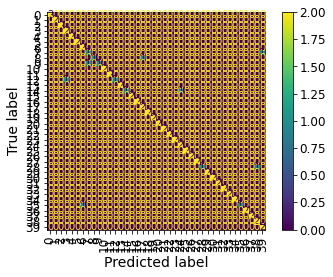

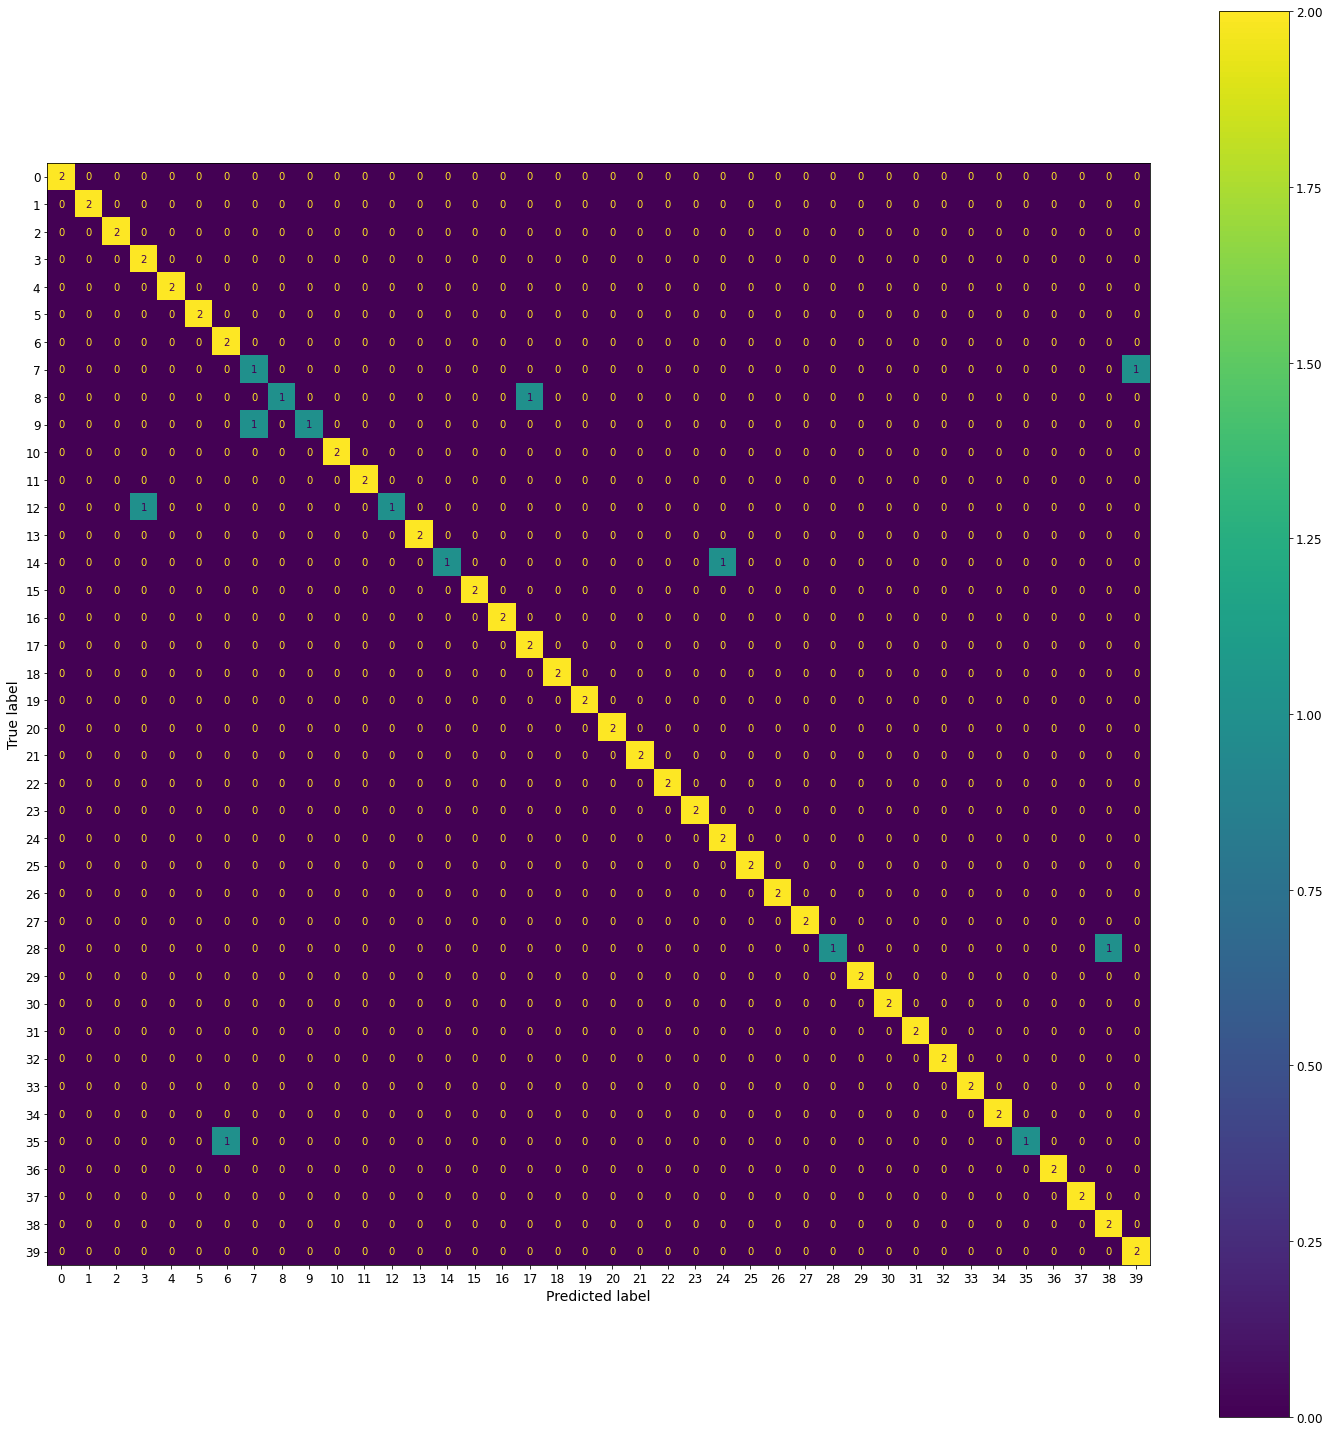

In [169]:
t0 = time()
y_pred = clf.predict(X_valid_pca)
print("done in %0.3fs" % (time() - t0))

#metricas(y_test, y_pred)
cmp=ConfusionMatrixDisplay.from_estimator(clf, X_valid_pca, y_valid, display_labels=np.unique(y_valid), xticks_rotation="vertical")
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)
plt.tight_layout()
plt.show()

### Validación

In [171]:
### train
print('Train:')
y_predict=clf.predict(X_train_pca)
metricas(y_train, y_predict)
### valid
print('Valid:')
y_predict=clf.predict(X_valid_pca)
metricas(y_valid, y_predict)


Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17       1